# Experiment 3

### Description of the experiment...

# NN arquitect is gonna be modify
# Is gonna add 5 parameters
- features.append(self.shares_held * current_price / self.cash)  # ratio posición/cash
- features.append(self.shares_held * current_price / self.initial_cash)  # % portfolio invertido
- features.append(row['Close']/row['SMA_20'])  # Precio relativo a media
- features.append(row['ATR_14']/row['Close'])  # Volatilidad normalizada
- features.append(row['RSI_14']/100)  # RSI en escala [0,1]

# Modify Actions

-    Acciones de COMPRA
-    0: 0.05,   # 5% del capital (operaciones pequeñas)
-    1: 0.10,   # 10% (tamaño estándar)
-    2: 0.20,   # 20% (operación confiable)
-    3: 0.35,   # 35% (alta convicción)
    
-    Acciones de VENTA
-    4: -0.10,  # Reducir 10% posición
-    5: -0.25,  # Reducir 25%
-    6: -0.50,  # Reducir 50%
-    7: -1.00,  # Salir completamente

# Modify Reward
Se creo todo un sistema de reward...

# Modify Hiperparametros
- learning_rate = 3e-4  # Más estable
- minibatch_size = 64   # Más común en DL
- discount_factor = 0.9  # Más enfoque en corto plazo
- replay_buffer_size = int(1e6)  # 10x mayor
- interpolation_parameter = 1e-2



Explanations...
- How works the actios... 
- How wroks the reward...

NN Architect:

- Input: 12 Nodes (Features)
- Hidden Layer 1: 128 Nodes (ReLU)
- Hidden Layer 2: 64 Nodes (ReLU)
- Output: 7 Nodes (Actions)

Input:
- **close_price:** Most recent closing price of Microsoft stock.
- **sma_5:** Average of last 5 closing prices, shows very short-term trend.
- **sma_20:** Average of last 20 closes, shows short to mid-term trend.
- **sma_50:** Average of last 50 closes, shows longer-term market trend.
- **rsi_14:** Relative Strength Index, detects overbought (>70) or oversold (<30) conditions.
- **macd:** Measures momentum by subtracting 26-EMA from 12-EMA.
- **macd_signal:** 9-day EMA of MACD, used to signal buy/sell crossovers.
- **bollinger_b:** Price's position relative to Bollinger Bands; near 1 means close to upper band.
- **atr_14:** Average True Range; shows volatility based on recent high-low price ranges.
- **momentum_10:** Difference between current price and price 10 days ago.
- **cash:** Current uninvested capital available to buy shares.
- **shares_held:** Number of MSFT shares currently owned by the agent.

+5

Output:
- **Hold:** Do nothing, maintain current position.
- **Buy small:** Buy a small number of shares using a small % of available cash.
- **Buy medium:** Buy more shares using a moderate % of cash.
- **Buy large:** Buy many shares using a large % of available cash.
- **Sell small:** Sell a small number of shares.
- **Sell medium:** Sell a moderate number of shares.
- **Sell all:** Sell all currently held shares.

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [34]:
testing_SPY = pd.read_csv('../Data/Train_Test/testing_SPY_e2.csv')
testing_SPY = testing_SPY.drop(['Unnamed: 0'], axis=1)
testing_SPY.head()

,Date,Close,SMA_5,SMA_20,SMA_50,RSI_14,MACD,MACD_Signal,Bollinger_b,ATR_14,Momentum_10
0,2005-01-03,82.073990,82.529770,81.819365,80.077552,55.102031,0.679712,0.757610,0.586922,0.627123,0.586655
1,2005-01-04,81.071144,82.209119,81.825521,80.209643,38.224783,0.540785,0.714245,0.239910,0.691627,-0.436623
2,2005-01-05,80.511719,81.752016,81.841393,80.332306,32.672397,0.381150,0.647626,0.018346,0.713740,-1.623726
3,2005-01-06,80.921066,81.408170,81.854305,80.440407,38.622213,0.284391,0.574979,0.151279,0.711091,-1.412231
4,2005-01-07,80.805069,81.076598,81.847157,80.528044,42.354400,0.196088,0.499201,0.116829,0.711969,-1.589622


In [35]:
#Add features to Testing
testing_SPY['Relative_price'] = testing_SPY['Close']/testing_SPY['SMA_20']
testing_SPY['Norm_Volatily'] = testing_SPY['ATR_14']/testing_SPY['Close']
testing_SPY['Scal_RSI'] = testing_SPY['RSI_14']/100

In [36]:
testing_SPY.head()

,Date,Close,SMA_5,SMA_20,SMA_50,RSI_14,MACD,MACD_Signal,Bollinger_b,ATR_14,Momentum_10,Relative_price,Norm_Volatily,Scal_RSI
0,2005-01-03,82.073990,82.529770,81.819365,80.077552,55.102031,0.679712,0.757610,0.586922,0.627123,0.586655,1.003112,0.007641,0.551020
1,2005-01-04,81.071144,82.209119,81.825521,80.209643,38.224783,0.540785,0.714245,0.239910,0.691627,-0.436623,0.990781,0.008531,0.382248
2,2005-01-05,80.511719,81.752016,81.841393,80.332306,32.672397,0.381150,0.647626,0.018346,0.713740,-1.623726,0.983753,0.008865,0.326724
3,2005-01-06,80.921066,81.408170,81.854305,80.440407,38.622213,0.284391,0.574979,0.151279,0.711091,-1.412231,0.988599,0.008787,0.386222
4,2005-01-07,80.805069,81.076598,81.847157,80.528044,42.354400,0.196088,0.499201,0.116829,0.711969,-1.589622,0.987268,0.008811,0.423544


In [37]:
testing_SPY.shape

(3523, 14)

In [38]:
training_SPY = pd.read_csv('../Data/Train_Test/training_SPY_e2.csv')
training_SPY = training_SPY.drop(['Unnamed: 0'], axis=1)
training_SPY.head()

,Date,Close,SMA_5,SMA_20,SMA_50,RSI_14,MACD,MACD_Signal,Bollinger_b,ATR_14,Momentum_10
0,2000-01-03,92.142548,92.746373,90.878498,88.689529,64.905610,1.209557,1.134688,0.706253,1.204466,1.742256
1,2000-01-04,88.539215,91.930681,90.793552,88.815921,48.025427,0.852350,1.078220,0.150906,1.382858,-1.207680
2,2000-01-05,88.697601,91.067470,90.753062,88.953776,46.416858,0.575409,0.977658,0.190058,1.478556,-2.415451
3,2000-01-06,87.272079,89.940936,90.669935,89.083660,38.638978,0.238158,0.829758,0.025521,1.580544,-4.078476
4,2000-01-07,92.340523,89.798393,90.818503,89.285683,56.171171,0.375536,0.738913,0.711398,1.873088,-0.465248


In [39]:
#Add features to Trading
training_SPY['Relative_price'] = training_SPY['Close']/training_SPY['SMA_20']
training_SPY['Norm_Volatily'] = training_SPY['ATR_14']/training_SPY['Close']
training_SPY['Scal_RSI'] = training_SPY['RSI_14']/100

In [40]:
training_SPY.head()

,Date,Close,SMA_5,SMA_20,SMA_50,RSI_14,MACD,MACD_Signal,Bollinger_b,ATR_14,Momentum_10,Relative_price,Norm_Volatily,Scal_RSI
0,2000-01-03,92.142548,92.746373,90.878498,88.689529,64.905610,1.209557,1.134688,0.706253,1.204466,1.742256,1.013909,0.013072,0.649056
1,2000-01-04,88.539215,91.930681,90.793552,88.815921,48.025427,0.852350,1.078220,0.150906,1.382858,-1.207680,0.975171,0.015619,0.480254
2,2000-01-05,88.697601,91.067470,90.753062,88.953776,46.416858,0.575409,0.977658,0.190058,1.478556,-2.415451,0.977351,0.016670,0.464169
3,2000-01-06,87.272079,89.940936,90.669935,89.083660,38.638978,0.238158,0.829758,0.025521,1.580544,-4.078476,0.962525,0.018111,0.386390
4,2000-01-07,92.340523,89.798393,90.818503,89.285683,56.171171,0.375536,0.738913,0.711398,1.873088,-0.465248,1.016759,0.020285,0.561712


In [41]:
training_SPY.shape

(1256, 14)

### Creating the architecture of the Neural Network

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from collections import deque
import math

In [43]:
class DQN(nn.Module):
    def __init__(self, input_dim=17, output_dim=8):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, output_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))  # [batch_size, 256]
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))  # [batch_size, 128]
        x = self.dropout(F.relu(self.fc3(x)))  # [batch_size, 64]
        x = self.fc4(x)  # ¡Esta línea faltaba! [batch_size, 8]
        return x

    # def forward(self, x):
    #     x = F.relu(self.bn1(self.fc1(x)))
    #     x = self.dropout(x)
    #     x = F.relu(self.bn2(self.fc2(x)))
    #     x = self.fc3(x)
    #     return x

### Create Custom Trading Environment

In [45]:
#Custom Trading Environment for a single stock
class TradingEnv:
    """
    Initialize the trading environment.
    """
    def __init__(self, df, initial_cash=10_000):
        # Load and sort data
        self.df = df.reset_index(drop=True).copy()
        self.max_steps = len(self.df) - 2  # total steps (days)

        # Initial portfolio settings
        self.initial_cash = initial_cash
        self.cash = initial_cash
        self.shares_held = 0.0
        self.current_step = 0
        self.prev_portfolio_value = initial_cash
        self.returns_history = []

        # Track total reward and history
        self.total_reward = 0
        self.history = []

        # Action mapping
        self.action_mapping = {
            0: 0.05,  # buy small
            1: 0.10,  # buy small - medium
            2: 0.20,  # buy large - medium
            3: 0.35,  # buy large
            4: 0.10,  # sell small
            5: 0.25,  # sell small - medium
            6: 0.50,  # sell large - medium
            7: 1.00   # sell all
        }

        # Define input features
        self.feature_cols = [
            'Close',
            'SMA_5', 'SMA_20', 'SMA_50',
            'RSI_14',
            'MACD', 'MACD_Signal',
            'Bollinger_b',
            'ATR_14',
            'Momentum_10',
            'Relative_price', 'Norm_Volatily', 'Scal_RSI'
        ]

    """
    Reset the environment to the initial state.
    """
    def reset(self):
        self.cash = self.initial_cash          # Reset available capital
        self.shares_held = 0.0                 # No shares at start
        self.current_step = 0                  # Start at the beginning of the dataset
        self.prev_portfolio_value = self.initial_cash  # Track portfolio for reward calc
        self.total_reward = 0.0                # Reset reward tracker
        self.history = []  
        self.returns_history = []# Clear history
    
        return self._get_state()

    """
    Construct the current state vector.
    """
    def _get_state(self):
        row = self.df.loc[self.current_step]
    
        # Extract the market features
        features = []
        for col in self.feature_cols:
            features.append(row[col])
    
        # Append portfolio state
        current_price = self.df.loc[self.current_step, 'Close']
        features.append(self.shares_held * current_price / self.cash)  # ratio position/cash (ADD)
        features.append(self.shares_held * current_price / self.initial_cash)  # % invest portfolio (ADD)
        features.append(self.cash)
        features.append(self.shares_held)
    
        return np.array(features, dtype=np.float32)

    def step(self, action):
        done = False
        reward = 0.0
        invalid_action_penalty = -.01
    
        current_price = self.df.loc[self.current_step, 'Close']
        action_type = self.action_mapping[action]

        #Make Step
        if 0 <= action <= 3:  # buy
            percent = self.action_mapping[action]
            if self.cash >= current_price * action_type:
                self._buy(percent)
        elif 4 <= action <= 7:  # sell
            percent = self.action_mapping[action]
            if self.shares_held > 0:
                self._sell(percent)

        #Get portfolio Value
        portfolio_value = self._get_portfolio_value()
        
        #Calculate Daily Return 
        daily_return = (portfolio_value - self.prev_portfolio_value) / (self.prev_portfolio_value + 1e-6)
        self.returns_history.append(daily_return)

        if len(self.returns_history) > 100:
            self.returns_history.pop(0)

        #Update peak_portfolio
        #self.peak_portfolio = max(self.peak_portfolio, portfolio_value)

        # Calculate reward 
        reward += self.calculate_reward(action)
        self.total_reward += reward

        # Advance to next time step
        self.current_step += 1
        
        #Get new Price of stock
        self.current_price = self.df.loc[self.current_step, 'Close']

        # Update prev_portfolio value
        self.prev_portfolio_value = portfolio_value
    
        # Log history for debugging/analysis
        self.history.append({
            'step': self.current_step,
            'cash': self.cash,
            'shares_held': self.shares_held,
            'portfolio_value': portfolio_value,
            'action': action,
            'reward': reward
        })

        done = self.current_step >= self.max_steps - 1
        if done:

            next_state = self._get_state()
            return next_state, reward, done, {}
    

        next_state = self._get_state()
        return next_state, reward, done, {}


    def calculate_reward(self, action):
        # Inicializar componentes
        rewards = {
            'pnl': 0.0,                  # Profit & Loss básico
            'risk_adjusted': 0.0,        # Retorno ajustado por riesgo
            'invalid_action': 0.0,       # Penalización por acción inválida
            'position_management': 0.0,  # Manejo de posición óptimo
            'trend_alignment': 0.0      # Alineación con tendencia
        }
        
        # 1. Componente PnL (base)
        current_value = self._get_portfolio_value()
        pnl = (current_value - self.prev_portfolio_value) / (self.prev_portfolio_value + 1e-6)
        rewards['pnl'] = np.clip(pnl * 5, -2.0, 2.0)  # Escalado y limitado
        
        # 2. Componente Ajustado por Riesgo (Sharpe-like)
        returns_window = np.array(self.returns_history[-20:])  # Últimos 20 retornos
        if len(returns_window) > 5:
            volatility = np.std(returns_window) + 1e-6
            risk_free = 0.0002  # Tasa libre de riesgo diaria aprox.
            sharpe_like = (np.mean(returns_window) - risk_free) / volatility
            rewards['risk_adjusted'] = np.clip(sharpe_like * 2, -1.5, 1.5)
        
        # 3. Penalización por Acción Inválida (¡Nueva recomendación!)
        invalid_penalty = self._get_invalid_action_penalty(action)
        rewards['invalid_action'] = invalid_penalty
        
        # 4. Gestión de Posición
        rewards['position_management'] = self._calculate_position_score()
        
        # 5. Alineación con Tendencia
        rewards['trend_alignment'] = self._calculate_trend_alignment()
        
        # Ponderación final
        weights = {
            'pnl': 0.4,
            'risk_adjusted': 0.3,
            'invalid_action': 0.15,
            'position_management': 0.1,
            'trend_alignment': 0.05
        }
        
        total_reward = sum(rewards[component] * weights[component] for component in rewards)
        return np.clip(total_reward, -3.0, 3.0)  # Limitar para estabilidad


    def _get_invalid_action_penalty(self, action):
        current_price = self.df.loc[self.current_step, 'Close']
        action_type = self.action_mapping[action]
        
        # Penalización base escalonada
        if (0 <= action <= 3) and (self.cash < current_price * action_type):
            # Intento de compra sin fondos
            base_penalty = -0.5
            
            # Penalización adicional proporcional a lo "ambicioso" de la acción
            ambition_penalty = -0.3 * action_type  # Más fuerte para acciones mayores
            
            return base_penalty + ambition_penalty
        
        elif (4 <= action <= 7) and (self.shares_held <= 0):
            # Intento de venta sin posición
            base_penalty = -0.4
            
            # Penalización por tamaño de orden de venta
            size_penalty = -0.2 * abs(action_type)
            
            return base_penalty + size_penalty
        
        return 0.0  # Acción válida

    def _calculate_position_score(self):
        """Evalúa qué tan óptima es la posición actual"""
        current_price = self.df.loc[self.current_step, 'Close']
        position_ratio = (self.shares_held * current_price) / self._get_portfolio_value()
        
        # Ideal: 30-70% invertido (evita estar totalmente en cash o totalmente invertido)
        optimal_min = 0.3
        optimal_max = 0.7
        
        if position_ratio < optimal_min:
            return -0.5 * (optimal_min - position_ratio)  # Penaliza estar bajo-invertido
        elif position_ratio > optimal_max:
            return -0.8 * (position_ratio - optimal_max)  # Penaliza más el sobre-invertir
        else:
            return 0.3  # Recompensa por estar en rango óptimo

    def _calculate_trend_alignment(self):
        """Recompensa alinear acciones con tendencia del mercado"""
        price_vs_sma = self.df.loc[self.current_step, 'Close'] / self.df.loc[self.current_step, 'SMA_20']
        rsi = self.df.loc[self.current_step, 'RSI_14']
        
        # Lógica de tendencia
        if price_vs_sma > 1.02 and rsi < 70:  # Tendencia alcista saludable
            return 0.4 if self.shares_held > 0 else -0.3
        elif price_vs_sma < 0.98 and rsi > 30:  # Tendencia bajista
            return 0.3 if self.shares_held == 0 else -0.4
        else:
            return 0.1 if abs(self.shares_held) < 0.1 else 0.0  # Mercado lateral

    def _get_portfolio_value(self):
        current_price = self.df.loc[self.current_step, 'Close']
        return self.cash + (self.shares_held * current_price)

    """
    Execute a buy order using a percentage of available cash.
    """
    def _buy(self, percent):
        current_price = self.df.loc[self.current_step, 'Close']
        
        # Capital to use for this transaction
        amount_to_spend = self.cash * percent
    
        # Number of whole shares we can buy
        shares_to_buy = int(amount_to_spend // current_price)
    
        if shares_to_buy > 0:
            self.cash -= shares_to_buy * current_price
            self.shares_held += shares_to_buy

    """
    Execute a sell order using a percentage of held shares.
    """
    def _sell(self, percent):
        current_price = self.df.loc[self.current_step, 'Close']
    
        # Determine how many shares to sell
        shares_to_sell = int(self.shares_held * percent)
    
        if shares_to_sell > 0:
            self.cash += shares_to_sell * current_price
            self.shares_held -= shares_to_sell
    

### Initializing the hyperparameters

In [46]:
# Learning rate for optimizer (controls how fast the model learns)
learning_rate = 3e-4 
# Number of experiences used for each learning step
minibatch_size = 64
# Discount factor (γ): how much future rewards are valued vs. immediate rewards
discount_factor = 0.9
#discount_factor = 0.99
# Size of the experience replay buffer
replay_buffer_size = int(1e6)
# Soft update rate (τ): how fast target network updates towards the main network
interpolation_parameter = 1e-2

### Implementing Experience Replay

In [47]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.capacity = capacity
        self.memory = []

    def push(self, event):
        self.memory.append(event)
        if len(self.memory) > self.capacity:
            del self.memory[0]

    def sample(self, batch_size):
        experiences = random.sample(self.memory, k=batch_size)
    
        states = torch.from_numpy(
            np.vstack([e[0] for e in experiences if e is not None])
        ).float().to(self.device)
    
        actions = torch.from_numpy(
            np.vstack([e[1] for e in experiences if e is not None])
        ).long().to(self.device)
    
        rewards = torch.from_numpy(
            np.vstack([e[2] for e in experiences if e is not None])
        ).float().to(self.device)
    
        next_states = torch.from_numpy(
            np.vstack([e[3] for e in experiences if e is not None])
        ).float().to(self.device)
    
        dones = torch.from_numpy(
            np.vstack([e[4] for e in experiences if e is not None]).astype(np.uint8)
        ).float().to(self.device)
    
        return states, next_states, actions, rewards, dones

    def __len__(self):
        return len(self.memory)

### Create DQN Agent

In [48]:
class Agent:
    def __init__(self, state_size, action_size):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.state_size = state_size
        self.action_size = action_size
        self.local_qnetwork = DQN(state_size, action_size).to(self.device)
        self.target_qnetwork = DQN(state_size, action_size).to(self.device)
        self.optimizer = optim.Adam(self.local_qnetwork.parameters(), lr = learning_rate)
        self.memory = ReplayMemory(replay_buffer_size)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        self.memory.push((state, action, reward, next_state, done))
        self.t_step = (self.t_step + 1) % 4
        if self.t_step == 0:
          if len(self.memory.memory) > minibatch_size:
            experiences = self.memory.sample(64)
            self.learn(experiences, discount_factor)

    def act(self, state, epsilon = 0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.local_qnetwork.eval()
        with torch.no_grad():
          action_values = self.local_qnetwork(state)
        self.local_qnetwork.train()
        if random.random() > epsilon:
          return np.argmax(action_values.cpu().data.numpy())
        else:
          return random.choice(np.arange(self.action_size))

    def learn(self, experiences, discount_factor):
        states, next_states, actions, rewards, dones = experiences
        next_q_targets = self.target_qnetwork(next_states).detach().max(1)[0].unsqueeze(1)
        q_targets = rewards + discount_factor * next_q_targets * (1 - dones)
        q_expected = self.local_qnetwork(states).gather(1, actions)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.soft_update(self.local_qnetwork, self.target_qnetwork, interpolation_parameter)

    def soft_update(self, local_model, target_model, interpolation_parameter):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
          target_param.data.copy_(interpolation_parameter * local_param.data + (1.0 - interpolation_parameter) * target_param.data)

### Initializing the DQN agent and Envirionment

In [49]:
agent = Agent(17, 8)
env = TradingEnv(training_SPY)

In [50]:
number_episodes = 2000
maximum_number_timesteps_per_episode = 1000
epsilon_starting_value  = 1.0
epsilon_ending_value  = 0.01
#epsilon_ending_value  = 0.1 
epsilon_decay_value  = 0.995
#epsilon_decay_value  = 0.95
epsilon = epsilon_starting_value
scores_on_100_episodes = deque(maxlen = 100)
total_value_on_100_episodes = deque(maxlen = 100)

for episode in range(1, number_episodes + 1):
    state = env.reset()
    score = 0
    #for t in range(maximum_number_timesteps_per_episode):
    for t in range(env.max_steps):
        action = agent.act(state, epsilon)
        next_state, reward, done, _ = env.step(action)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
          break
    scores_on_100_episodes.append(score)
    total_value_on_100_episodes.append(env.prev_portfolio_value)
    epsilon = max(epsilon_ending_value, epsilon_decay_value * epsilon)
    
    print('\rEpisode {}  Score: {:.2f} Initial Catch: {:.2f}  Total Catch {:.2f}, Total Holds:{}, Price stock: {:.2f}, Total Value: {:.2f}'.format(episode, score, env.initial_cash, env.cash, env.shares_held, env.current_price, env.prev_portfolio_value), end = "")
    
    if episode % 100 == 0:
        print('')
        print('\rEpisode {}  Average Reward: {:.2f} Average Total Value: {:.2f}'.format(episode, np.mean(scores_on_100_episodes), np.mean(total_value_on_100_episodes)))

torch.save(agent.local_qnetwork.state_dict(), 'Models/dqn_trading_Experiment_3.pth')

Episode 100  Score: -2.56 Initial Catch: 10000.00  Total Catch 3230.81, Total Holds:99.0, Price stock: 82.80, Total Value: 11415.589
Episode 100  Average Reward: -24.74 Average Total Value: 10003.57
Episode 200  Score: -6.42 Initial Catch: 10000.00  Total Catch 3792.04, Total Holds:57.0, Price stock: 82.80, Total Value: 8504.4896
Episode 200  Average Reward: -3.31 Average Total Value: 9870.23
Episode 300  Score: -2.55 Initial Catch: 10000.00  Total Catch 7547.78, Total Holds:45.0, Price stock: 82.80, Total Value: 11268.138
Episode 300  Average Reward: 6.40 Average Total Value: 10227.77
Episode 400  Score: 12.11 Initial Catch: 10000.00  Total Catch 7121.87, Total Holds:33.0, Price stock: 82.80, Total Value: 9850.1282
Episode 400  Average Reward: 5.77 Average Total Value: 10217.27
Episode 500  Score: 4.69 Initial Catch: 10000.00  Total Catch 2757.08, Total Holds:57.0, Price stock: 82.80, Total Value: 7469.52264
Episode 500  Average Reward: 9.24 Average Total Value: 10200.81
Episode 600  

In [56]:
test_env = TradingEnv(testing_SPY)

In [60]:
# Recreate the model architecture
trained_model = DQN(input_dim=17, output_dim=8)  # adjust if your input/output sizes changed

# Load the weights
trained_model.load_state_dict(torch.load('Models/dqn_trading_Experiment_3.pth'))
trained_model.eval()  # Set to evaluation mode

DQN(
  (fc1): Linear(in_features=17, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=8, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [61]:
state = test_env.reset()
done = False
total_reward = 0
actions = []
stocks_held = []
actual_cash = []
stock_price = []
portfolio_values = []

while not done:
    
    state_tensor = torch.from_numpy(state).float().unsqueeze(0)

    with torch.no_grad():
        action_values = trained_model(state_tensor)

    # print("Valores de acción (8 valores):", action_values)
    # print("Máxima acción posible:", torch.argmax(action_values).item())
    action = torch.argmax(action_values).item()
    #print(action)
    next_state, reward, done, _ = test_env.step(action)

    total_reward += reward


    actions.append(action)
    stocks_held.append(test_env.shares_held)
    actual_cash.append(test_env.cash)
    stock_price.append(test_env.current_price)
    portfolio_values.append(test_env.prev_portfolio_value)
    
    state = next_state

print("Total Reward:", total_reward)
print("Final Portfolio Value:", test_env.prev_portfolio_value)

Total Reward: -517.2462897362141
Final Portfolio Value: 15565.88314437866


### Visualize Result

In [62]:
SPY_stocks = pd.read_csv("../data/Preprocessed/SPY_Data.csv")
SPY_stocks = SPY_stocks.drop(['Unnamed: 0'], axis=1)
SPY_stocks.head()

,Date,High,Low,Close
0,1999-07-26,85.789774,84.844432,84.923210
1,1999-07-27,86.469216,85.317081,85.632195
2,1999-07-28,86.538133,85.454929,85.907906
3,1999-07-29,85.238351,84.017284,84.706596
4,1999-07-30,85.297373,83.544552,83.662720


In [63]:
def group_actions(valor):
    valor = valor.lower()
    if "buy" in valor:
        return "buy"
    elif "sell" in valor:
        return "sell"
    elif "hold" in valor:
        return "hold"

In [64]:
#SPY_stocks = SPY_stocks.drop(['Unnamed: 0'], axis=1)

test_vis_SPY = SPY_stocks[SPY_stocks['Date'] >= '2005-01-01']
test_vis_SPY = test_vis_SPY[test_vis_SPY['Date'] <= '2019-01-01']
test_vis_SPY = test_vis_SPY.drop(test_vis_SPY.index[0])
test_vis_SPY = test_vis_SPY.drop(test_vis_SPY.tail(2).index)
test_vis_SPY = test_vis_SPY.drop(['High', 'Low'], axis=1)
test_vis_SPY['v_Close'] = stock_price
test_vis_SPY['Prev_Action'] = actions
test_vis_SPY['Stocks_Held'] = stocks_held
test_vis_SPY['Actual_Cash'] = actual_cash
test_vis_SPY['Portfolio_Values'] = portfolio_values

test_vis_SPY['Prev_Action'] = test_vis_SPY['Prev_Action'].map({
    0: "Buy Small",
    1: "Buy Small - Medium",
    2: "Buy Large - Medium",
    3: "Buy Large",
    4: "Sell Small",
    5: "Sell Small - Medium",
    6: "Sell Large - Medium",
    7: "Sell Large"
})

test_vis_SPY['Stocks_Money'] = test_vis_SPY['Close'] * test_vis_SPY['Stocks_Held']
test_vis_SPY['Color_Action'] = test_vis_SPY['Prev_Action'].apply(group_actions)

test_vis_SPY.head(10)

,Date,Close,v_Close,Prev_Action,Stocks_Held,Actual_Cash,Portfolio_Values,Stocks_Money,Color_Action
1369,2005-01-04,81.071144,81.071144,Buy Large - Medium,24.0,8030.224243,10000.000000,1945.707458,buy
1370,2005-01-05,80.511719,80.511719,Buy Small - Medium,33.0,7300.583946,9975.931702,2656.886719,buy
1371,2005-01-06,80.921066,80.921066,Sell Small,30.0,7542.119102,9957.470665,2427.631989,sell
1372,2005-01-07,80.805069,80.805069,Buy Small,34.0,7218.434837,9969.751091,2747.372345,buy
1373,2005-01-10,81.187134,81.187134,Buy Small - Medium,42.0,6571.994286,9965.807182,3409.859619,buy
1374,2005-01-11,80.627693,80.627693,Sell Small,38.0,6896.742821,9981.853905,3063.852341,sell
1375,2005-01-12,80.893738,80.893738,Sell Small,35.0,7138.625900,9960.595161,2831.280823,sell
1376,2005-01-13,80.245613,80.245613,Sell Small,32.0,7381.307114,9969.906723,2567.859619,sell
1377,2005-01-14,80.668640,80.668640,Sell Small,29.0,7622.043953,9949.166733,2339.390564,sell
1378,2005-01-18,81.507767,81.507767,Sell Small,27.0,7783.381233,9961.434517,2200.709702,sell


In [65]:
normal_final_invest = 10000 * (test_vis_SPY['Close'].iloc[-1] / test_vis_SPY['Close'].iloc[0])

print("Stock Prices First Day:", test_vis_SPY['Close'].iloc[0])
print("Stock Prices Last Day:", test_vis_SPY['Close'].iloc[-1])
print("Final Portfolio Value if you will invest $10,000 normal:", normal_final_invest)
print("Final Portfolio Value if invest $10,000 with Trading Bot:", test_env.prev_portfolio_value)

Stock Prices First Day: 81.0711441040039
Stock Prices Last Day: 224.37730407714844
Final Portfolio Value if you will invest $10,000 normal: 27676.592770086118
Final Portfolio Value if invest $10,000 with Trading Bot: 15565.88314437866


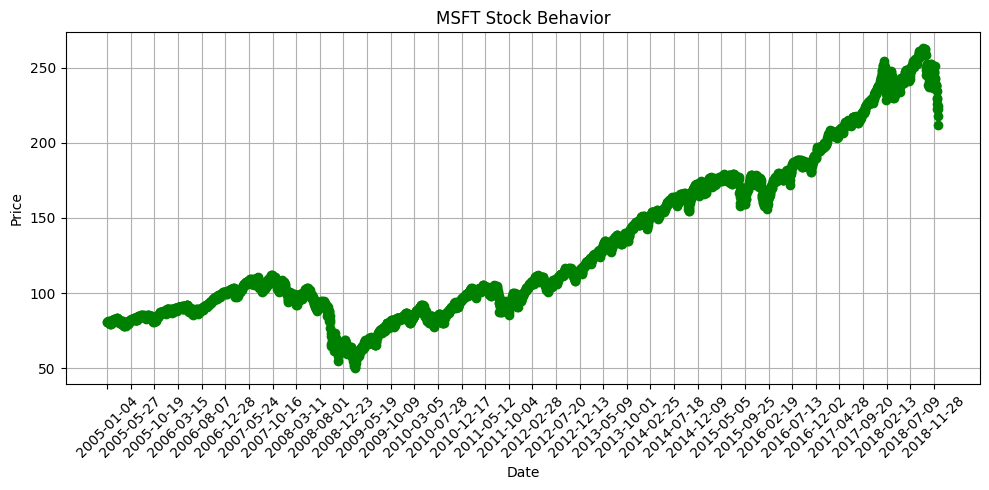

In [66]:
plt.figure(figsize=(10, 5))
plt.plot(test_vis_SPY['Date'], test_vis_SPY['Close'], marker='o', linestyle='-', color='green')
plt.title('MSFT Stock Behavior')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)

skip = 100
plt.xticks(test_vis_SPY['Date'][::skip], rotation=45)

plt.tight_layout()
plt.show()

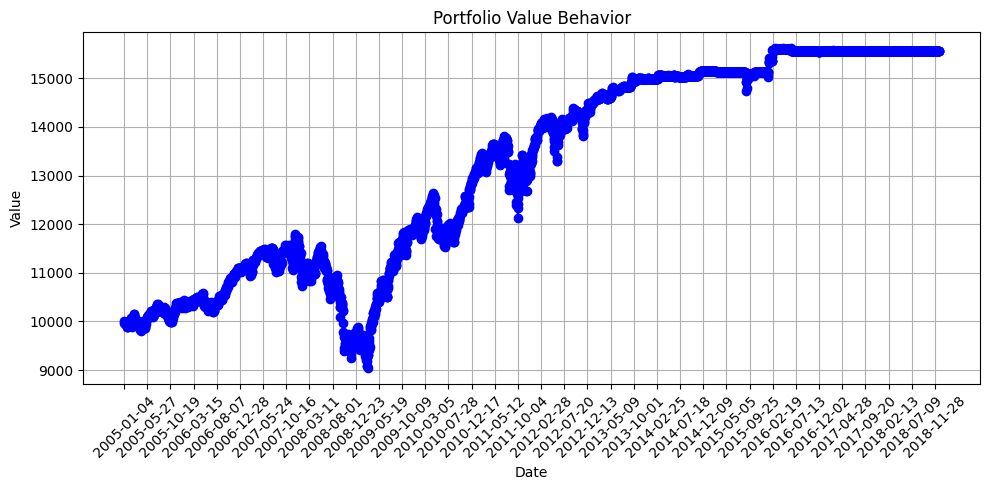

In [67]:
plt.figure(figsize=(10, 5))
plt.plot(test_vis_SPY['Date'], test_vis_SPY['Portfolio_Values'], marker='o', linestyle='-', color='blue')
plt.title('Portfolio Value Behavior')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)

skip = 100
plt.xticks(test_vis_SPY['Date'][::skip], rotation=45)

plt.tight_layout()
plt.show()

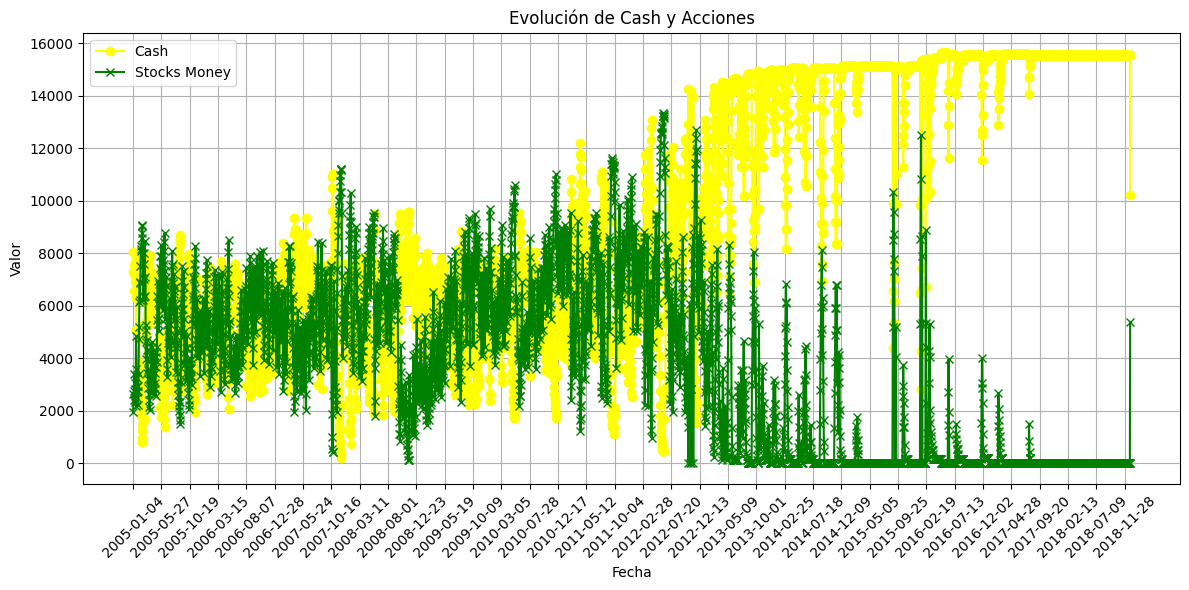

In [68]:
plt.figure(figsize=(12, 6))

plt.plot(test_vis_SPY['Date'], test_vis_SPY['Actual_Cash'], label='Cash', color='Yellow', marker='o')
plt.plot(test_vis_SPY['Date'], test_vis_SPY['Stocks_Money'], label='Stocks Money', color='Green', marker='x')

# Configuración general
plt.title('Evolución de Cash y Acciones')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)

skip = 100
plt.xticks(test_vis_SPY['Date'][::skip], rotation=45)

plt.tight_layout()

# Mostrar
plt.show()

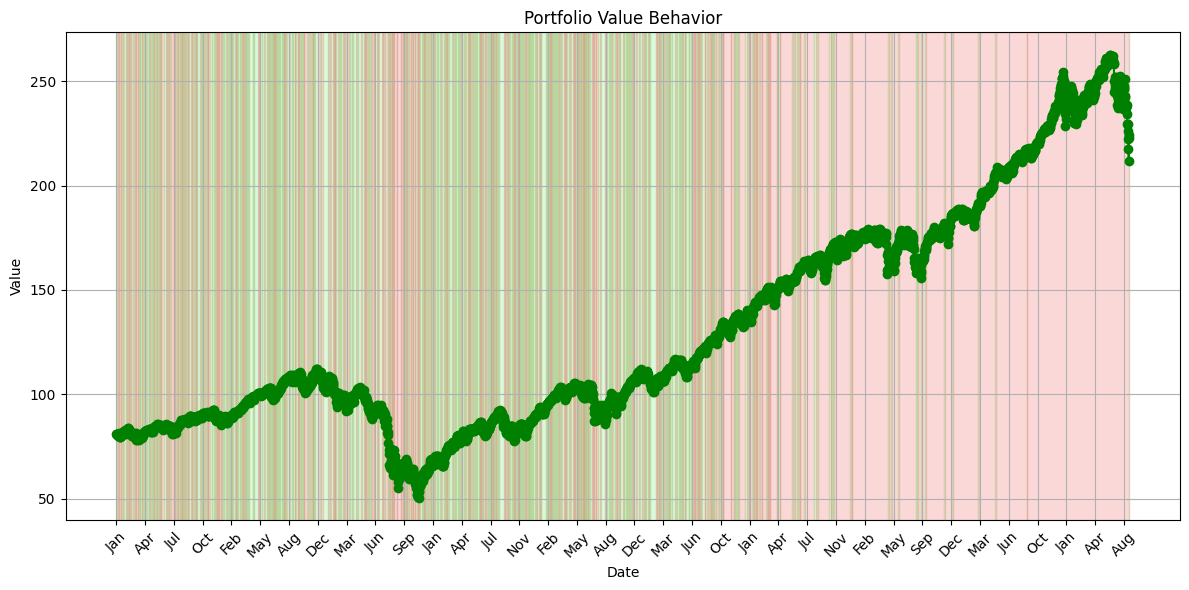

In [69]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(test_vis_SPY['Date'], test_vis_SPY['Close'], color='green', marker='o')

state_colors = {
    'buy': 'lightgreen',
    'sell': 'lightcoral',
    'hold': 'lightyellow'
}

prev_state = None
start_date = None

for i, row in test_vis_SPY.iterrows():
    current_state = row['Color_Action']
    current_date = row['Date']

    if current_state != prev_state:
        if prev_state is not None:
            ax.axvspan(start_date, current_date, color=state_colors[prev_state], alpha=0.3)
        start_date = current_date
        prev_state = current_state

ax.axvspan(start_date, test_vis_SPY['Date'].iloc[-1], color=state_colors[prev_state], alpha=0.3)

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.title("Portfolio Value Behavior")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)

skip = 100
plt.xticks(test_vis_SPY['Date'][::skip], rotation=45)

plt.tight_layout()
plt.show()